In [ ]:
# -*- coding: utf-8 -*-
import argparse
import os
import pickle as pkl
import random

import numpy as np
import torch
# import torch.distributed
import wandb
from ase.units import GPa

from mattersim.datasets.utils.build import build_dataloader
from mattersim.forcefield.m3gnet.scaling import AtomScaling
from mattersim.forcefield.potential import Potential
from mattersim.utils.atoms_utils import AtomsAdaptor
from mattersim.utils.logger_utils import get_logger

from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import pandas as pd

/global/cfs/projectdirs/m4555/Jun/conda_envs/mattersim-LR/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/global/cfs/projectdirs/m4555/Jun/conda_envs/mattersim-LR/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadat

2025-11-04 11:33:01.668 | INFO     | mattersim.forcefield.potential:from_checkpoint:905 - Loading the model from ./results/best_model.pth


In [2]:
atoms_val = AtomsAdaptor.from_file(filename="../../data/benchmarks/val_water_1593_eVAng.xyz")
energies = []
forces = [] 
for atoms in atoms_val:
    energies.append(atoms.get_potential_energy() / len(atoms)) 
    forces.append(atoms.get_forces())

print(f"Processed {len(atoms_val)} validation data")

val_dataloader = build_dataloader(
    atoms_val,
    energies,
    forces,
    pin_memory=True,
    is_distributed=False,
    shuffle=False,
    batch_size=16
)

potential = Potential.from_checkpoint(
    load_path="./results/best_model.pth",
    load_training_state=False,
    long_range=True
)

predicted_energies, predicted_forces, _, charges = potential.predict_properties(
    val_dataloader,
    include_forces=True,
    include_stresses=False
)

predicted_energies = np.array(predicted_energies) / len(atoms)

true_energies, true_forces = energies, forces

Processed 160 validation data
Total charges:	 tensor([ 4.2915e-05,  4.9353e-05,  3.2187e-05, -1.5998e-04,  1.2660e-04,
         1.2541e-04,  6.9141e-05, -1.0729e-05,  4.5538e-05,  5.5075e-05,
         7.6294e-06,  9.3460e-05, -7.7963e-05, -2.0623e-04, -3.2187e-05,
        -4.3154e-05], device='cuda:0', grad_fn=<ScatterAddBackward0>)
Total charges:	 tensor([-1.0037e-04, -5.0068e-05,  4.6015e-05,  2.5988e-05,  3.1710e-05,
        -7.6532e-05,  1.1587e-04,  1.4305e-05,  7.6532e-05, -5.0068e-05,
         1.5569e-04,  3.8624e-05,  1.1134e-04,  1.3852e-04,  4.6015e-05,
         7.5579e-05], device='cuda:0', grad_fn=<ScatterAddBackward0>)
Total charges:	 tensor([-3.8624e-05,  6.1512e-05,  4.7207e-05, -6.8903e-05, -1.4782e-05,
        -1.2064e-04, -6.1512e-05,  3.9816e-05, -6.5088e-05,  4.0293e-05,
         1.5879e-04, -7.7963e-05,  6.2943e-05, -1.6356e-04, -1.1921e-06,
         5.0306e-05], device='cuda:0', grad_fn=<ScatterAddBackward0>)
Total charges:	 tensor([-1.1683e-05, -1.5998e-04, -8.51

In [3]:
element_list = []
for i in range(len(atoms_val)):
    element_list += atoms_val[i].get_chemical_symbols()

In [4]:
df = pd.DataFrame({"Atoms": element_list, "Predicted Charges": charges})
df

,Atoms,Predicted Charges
0,O,-3.339052
1,H,2.230843
2,H,1.796834
3,O,-3.470481
4,H,1.593892
...,...,...
30715,H,1.637924
30716,H,1.588632
30717,O,-3.438089
30718,H,1.688517


-2.2470951080322267e-06


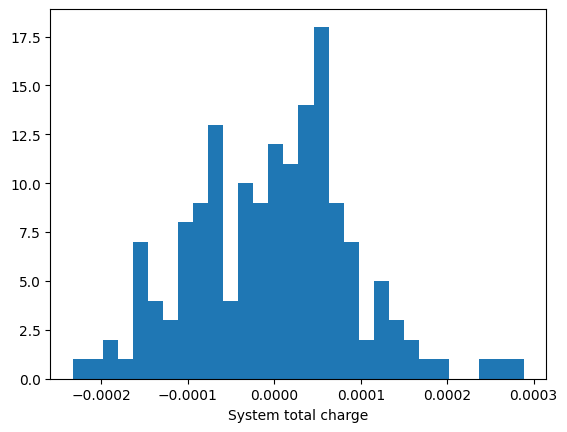

In [5]:
count = 0
system_charge = []
for i in atoms_val:
    system_charge.append(sum(df["Predicted Charges"].iloc[count:count+len(i)]))
    count += len(i)

plt.hist(np.array(system_charge), bins=30)
plt.xlabel("System total charge")
print(np.array(system_charge).mean())

-3.511086106300354e-08


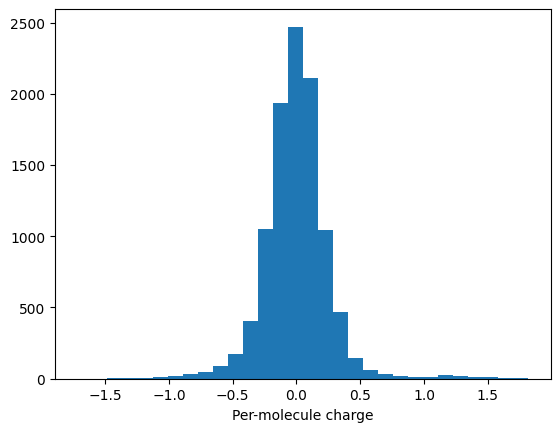

In [6]:
molecule_charge = []
for i in range(0, len(df), 3):
    molecule_charge.append(sum(df["Predicted Charges"].iloc[i:i+3]))

plt.hist(np.array(molecule_charge), bins=30)
plt.xlabel("Per-molecule charge")

print(np.array(molecule_charge).mean())

(0.0, 8332.0)

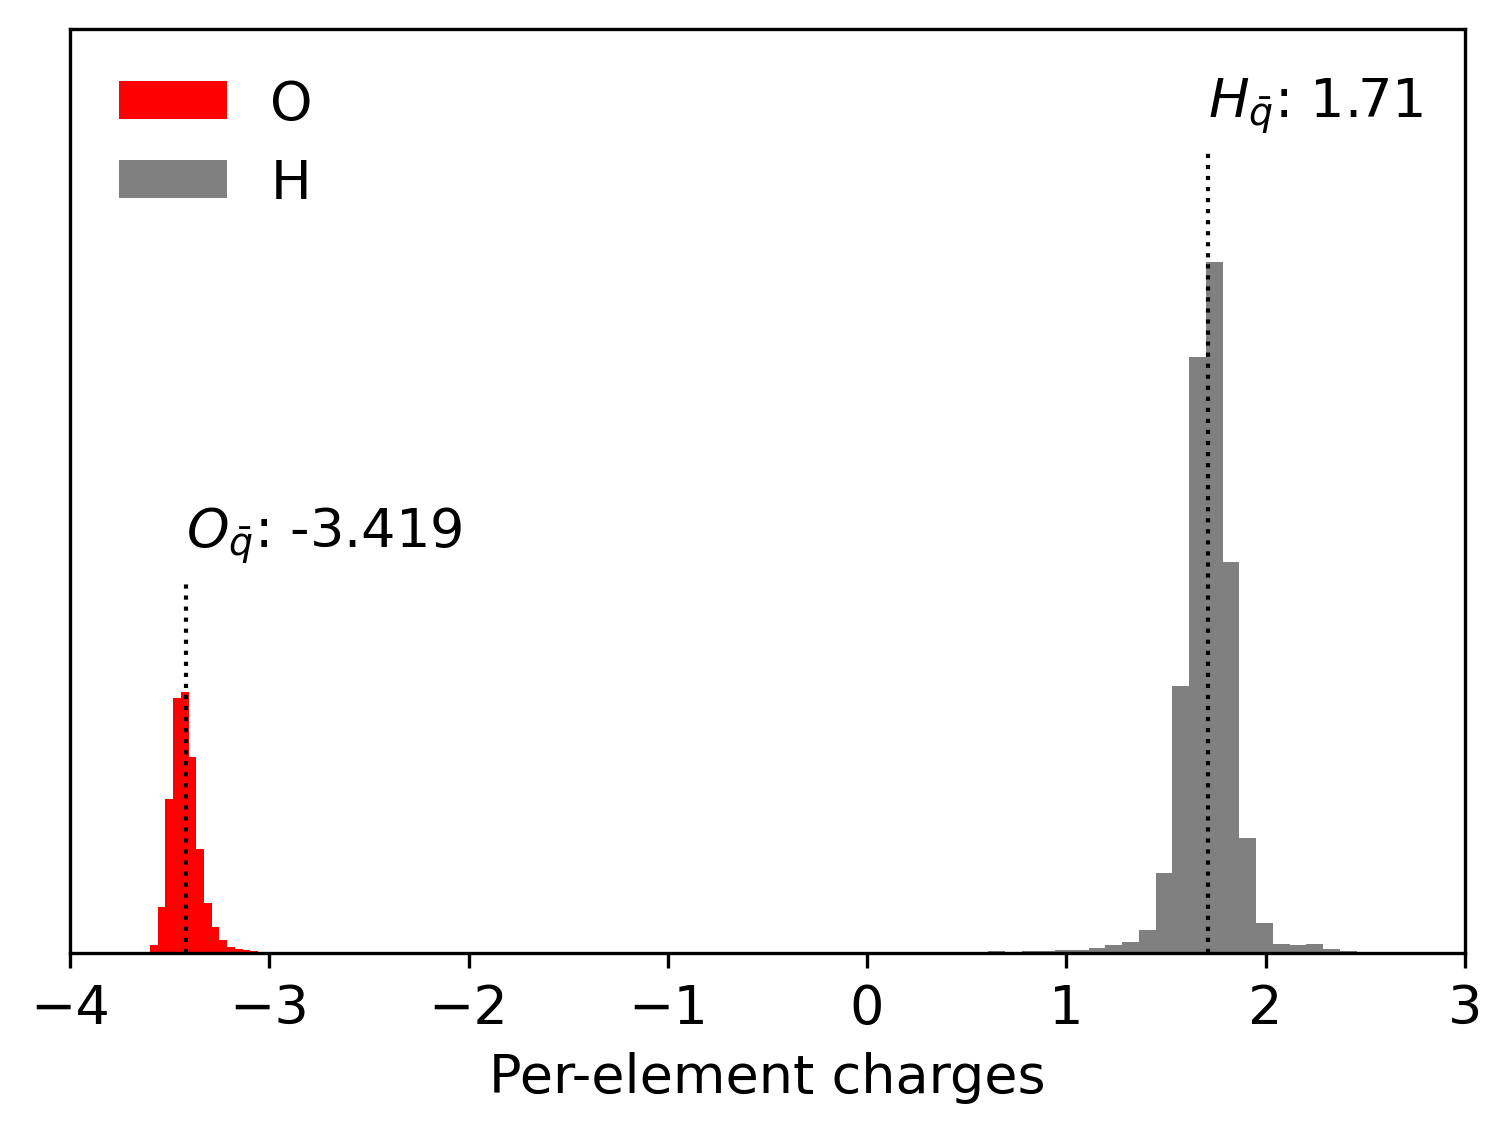

In [110]:
O = df[df["Atoms"] == "O"]["Predicted Charges"]
H = df[df["Atoms"] == "H"]["Predicted Charges"]

plt.figure(figsize=(6,4), dpi=300)

counts_O, bins, _ = plt.hist(O, bins=30, color='red', label="O")
counts_H, bins, _ = plt.hist(H, bins=30, color ='grey', label = "H")
plt.xlabel("Per-element charges", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks([])
plt.xlim([-4,3])

plt.legend(frameon=False, fontsize=13)

O_mean = round(float(O.mean()), 3)
H_mean = round(float(H.mean()), 3)

plt.vlines(O_mean, 0, max(counts_O) + 1000, linestyles=':', linewidth=1, color='black')
plt.vlines(H_mean, 0, max(counts_H) + 1000, linestyles=':', linewidth=1, color='black')

plt.annotate(rf"$O_{{\bar{{q}}}}$: {O_mean}", (O_mean, max(counts_O) + 1300), fontsize=13)
plt.annotate(rf"$H_{{\bar{{q}}}}$: {H_mean}", (H_mean, max(counts_H) + 1300), fontsize=13)

plt.ylim([0, max(counts_H)+2100])